# Euclid Q1: MER mosaics

## Learning Goals

By the end of this tutorial, you will:
- understand the basic characteristics of Euclid Q1 MER mosaics;
- know how to download full MER mosaics;
- know how to make smaller cutouts of MER mosaics;
- know how to use matplotlib to plot a grid of cutouts;
- know how to identify sources in the cutouts and make basic measurements.

## Introduction

Euclid launched in July 2023 as a European Space Agency (ESA) mission with involvement by NASA.
The primary science goals of Euclid are to better understand the composition and evolution of the dark Universe.
The Euclid mission is providing space-based imaging and spectroscopy as well as supporting ground-based imaging to achieve these primary goals.
These data will be archived by multiple global repositories, including IRSA, where they will support transformational work in many areas of astrophysics.

Euclid Quick Release 1 (Q1) consists of consists of ~30 TB of imaging, spectroscopy, and catalogs covering four non-contiguous fields:
Euclid Deep Field North (22.9 sq deg), Euclid Deep Field Fornax (12.1 sq deg), Euclid Deep Field South (28.1 sq deg), and LDN1641.

Among the data products included in the Q1 release are the Level 2 MER mosaics.
These are multiwavelength mosaics created from images taken with the Euclid instruments (VIS and NISP), as well as a variety of ground-based telescopes.
All of the mosaics have been created according to a uniform tiling on the sky, and mapped to a common pixel scale.
This notebook provides a quick introduction to accessing MER mosaics from IRSA.
If you have questions about it, please contact the [IRSA helpdesk](https://irsa.ipac.caltech.edu/docs/help_desk.html).

## Data volume

Each MER image is approximately 1.47 GB. Downloading can take some time.

## Imports

```{important}
We rely on ``astroquery`` and ``sep`` features that have been recently added, so please make sure you have the respective version v0.4.10 and v1.4 or newer installed.
```

In [1]:
# Uncomment the next line to install dependencies if needed.
# !pip install numpy 'astropy>=5.3' matplotlib 'astroquery>=0.4.10' 'sep>=1.4' fsspec

In [2]:
import re

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch,  ZScaleInterval, SquaredStretch
from astropy.wcs import WCS
from astropy import units as u

from astroquery.ipac.irsa import Irsa
import sep

## 1. Search for multiwavelength Euclid Q1 MER mosaics that cover the star HD 168151
Below we set a search radius of 10 arcsec and convert the name "HD 168151" into coordinates.

In [3]:
search_radius = 10 * u.arcsec
coord = SkyCoord.from_name('HD 168151')

Use IRSA's Simple Image Access (SIA) API to search for all Euclid MER mosaics that overlap with the search region you have specified. We specify the euclid_DpdMerBksMosaic "collection" because it lists all of the multiwavelength MER mosaics, along with their associated catalogs.

```{tip}
The IRSA SIA collections can be listed using using the ``list_collections`` method, we can filter on the ones containing "euclid" in the collection name:

    Irsa.list_collections(filter='euclid')
```

In [4]:
image_table = Irsa.query_sia(pos=(coord, search_radius), collection='euclid_DpdMerBksMosaic')

This table lists all MER mosaic images available in this search position. These mosaics include the Euclid VIS, Y, J, H images, as well as ground-based telescopes which have been put on the same pixel scale. For more information, see the [Euclid documentation at IPAC](https://euclid.caltech.edu/page/euclid-faq-tech/).

Note that there are various image types are returned as well, we filter out the `science` images from these:

In [5]:
science_images = image_table[image_table['dataproduct_subtype'] == 'science']
science_images

s_ra,s_dec,facility_name,instrument_name,dataproduct_subtype,calib_level,dataproduct_type,energy_bandpassname,energy_emband,obs_id,s_resolution,em_min,em_max,em_res_power,proposal_title,access_url,access_format,access_estsize,t_exptime,s_region,obs_collection,obs_intent,algorithm_name,facility_keywords,instrument_keywords,environment_photometric,proposal_id,proposal_pi,proposal_project,target_name,target_type,target_standard,target_moving,target_keywords,obs_release_date,s_xel1,s_xel2,s_pixel_scale,position_timedependent,t_min,t_max,t_resolution,t_xel,obs_publisher_did,s_fov,em_xel,pol_states,pol_xel,cloud_access,o_ucd,upload_row_id
deg,deg,,,,,,,,,arcsec,m,m,,,,,kbyte,s,deg,,,,,,,,,,,,,,,,,,arcsec,,d,d,s,,,deg,,,,,,
float64,float64,object,object,object,int16,object,object,object,object,float64,float64,float64,float64,object,object,object,int64,float64,object,object,object,object,object,object,bool,object,object,object,object,object,bool,bool,object,object,int64,int64,float64,bool,float64,float64,float64,int64,object,float64,int64,object,int64,object,object,int64
273.74061163858784,64.50001388888538,CFHT,MegaCam,science,3,image,R,Optical,102158277_MegaCam,--,5.61762e-07,7.22025e-07,4.0,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/MEGACAM/EUC_MER_BGSUB-MOSAIC-CFIS-R_TILE102158277-CA7AB3_20241025T120300.417407Z_00.00.fits,image/fits,1474566,--,POLYGON ICRS 274.366109291086 64.76536207691132 273.11511335805267 64.76536180261205 273.1272020139886 64.23206348982802 274.3540218940251 64.23206375763488 274.366109291086 64.76536207691132,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,--,,,,,field,--,False,,2025-05-01 00:00:00,19200,19200,0.100000000000008,False,--,--,--,--,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102158277_MegaCam/R,0.533333333333376,--,,--,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102158277/MEGACAM/EUC_MER_BGSUB-MOSAIC-CFIS-R_TILE102158277-CA7AB3_20241025T120300.417407Z_00.00.fits"", ""region"": ""us-east-1""}}",,1
273.74061163858784,64.50001388888538,Euclid,VIS,science,3,image,VIS,Optical,102158277_VIS,0.16,5.5e-07,9e-07,2.1,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/VIS/EUC_MER_BGSUB-MOSAIC-VIS_TILE102158277-27C4DD_20241025T124812.358980Z_00.00.fits,image/fits,1474566,--,POLYGON ICRS 274.366109291086 64.76536207691132 273.11511335805267 64.76536180261205 273.1272020139886 64.23206348982802 274.3540218940251 64.23206375763488 274.366109291086 64.76536207691132,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,--,,,,,field,--,False,,2025-05-01 00:00:00,19200,19200,0.100000000000008,False,--,--,--,--,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102158277_VIS/VIS,0.533333333333376,--,,--,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102158277/VIS/EUC_MER_BGSUB-MOSAIC-VIS_TILE102158277-27C4DD_20241025T124812.358980Z_00.00.fits"", ""region"": ""us-east-1""}}",,1
273.74061163858784,64.50001388888538,CFHT,MegaCam,science,3,image,U,Optical,102158277_MegaCam,--,3.14751e-07,4.01839e-07,4.1,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/MEGACAM/EUC_MER_BGSUB-MOSAIC-CFIS-U_TILE102158277-DB8920_20241025T120138.608462Z_00.00.fits,image/fits,1474566,--,POLYGON ICRS 274.366109291086 64.76536207691132 273.11511335805267 64.76536180261205 273.1272020139886 64.23206348982802 274.3540218940251 64.23206375763488 274.366109291086 64.76536207691132,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,--,,,,,field,--,False,,2025-05-01 00:00:00,19200,19200,0.100000000000008,False,--,--,--,--,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102158277_MegaCam/U,0.533333333333376,--,,--,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102158277/MEGACAM/EUC_MER_BGSUB-MOSAIC-CFIS-U_TILE102158277-DB8920_20241025T120138.608462Z_00.00.fits"", ""region"": ""us-east-1""}}",,1
273.74061163858784,64.50001388888538,Subaru Telescope,Hyper Suprime-Cam,science,3,image,G,Optical,102158277_WISHES,1.58,3.95422e-07,5.54729e-07

## 2. Retrieve a Euclid Q1 MER mosaic image in the VIS bandpass

### Let's first look at one example full image, the VIS image

Note that 'access_estsize' is in units of kb

In [6]:
filename = science_images[science_images['energy_bandpassname'] == 'VIS']['access_url'][0]
filesize = science_images[science_images['energy_bandpassname'] == 'VIS']['access_estsize'][0] / 1000000
print(filename)

print(f'Please note this image is {filesize} GB. With 230 Mbps internet download speed, it takes about 1 minute to download.')

https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/VIS/EUC_MER_BGSUB-MOSAIC-VIS_TILE102158277-27C4DD_20241025T124812.358980Z_00.00.fits
Please note this image is 1.474566 GB. With 230 Mbps internet download speed, it takes about 1 minute to download.


In [7]:
science_images

s_ra,s_dec,facility_name,instrument_name,dataproduct_subtype,calib_level,dataproduct_type,energy_bandpassname,energy_emband,obs_id,s_resolution,em_min,em_max,em_res_power,proposal_title,access_url,access_format,access_estsize,t_exptime,s_region,obs_collection,obs_intent,algorithm_name,facility_keywords,instrument_keywords,environment_photometric,proposal_id,proposal_pi,proposal_project,target_name,target_type,target_standard,target_moving,target_keywords,obs_release_date,s_xel1,s_xel2,s_pixel_scale,position_timedependent,t_min,t_max,t_resolution,t_xel,obs_publisher_did,s_fov,em_xel,pol_states,pol_xel,cloud_access,o_ucd,upload_row_id
deg,deg,,,,,,,,,arcsec,m,m,,,,,kbyte,s,deg,,,,,,,,,,,,,,,,,,arcsec,,d,d,s,,,deg,,,,,,
float64,float64,object,object,object,int16,object,object,object,object,float64,float64,float64,float64,object,object,object,int64,float64,object,object,object,object,object,object,bool,object,object,object,object,object,bool,bool,object,object,int64,int64,float64,bool,float64,float64,float64,int64,object,float64,int64,object,int64,object,object,int64
273.74061163858784,64.50001388888538,CFHT,MegaCam,science,3,image,R,Optical,102158277_MegaCam,--,5.61762e-07,7.22025e-07,4.0,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/MEGACAM/EUC_MER_BGSUB-MOSAIC-CFIS-R_TILE102158277-CA7AB3_20241025T120300.417407Z_00.00.fits,image/fits,1474566,--,POLYGON ICRS 274.366109291086 64.76536207691132 273.11511335805267 64.76536180261205 273.1272020139886 64.23206348982802 274.3540218940251 64.23206375763488 274.366109291086 64.76536207691132,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,--,,,,,field,--,False,,2025-05-01 00:00:00,19200,19200,0.100000000000008,False,--,--,--,--,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102158277_MegaCam/R,0.533333333333376,--,,--,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102158277/MEGACAM/EUC_MER_BGSUB-MOSAIC-CFIS-R_TILE102158277-CA7AB3_20241025T120300.417407Z_00.00.fits"", ""region"": ""us-east-1""}}",,1
273.74061163858784,64.50001388888538,Euclid,VIS,science,3,image,VIS,Optical,102158277_VIS,0.16,5.5e-07,9e-07,2.1,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/VIS/EUC_MER_BGSUB-MOSAIC-VIS_TILE102158277-27C4DD_20241025T124812.358980Z_00.00.fits,image/fits,1474566,--,POLYGON ICRS 274.366109291086 64.76536207691132 273.11511335805267 64.76536180261205 273.1272020139886 64.23206348982802 274.3540218940251 64.23206375763488 274.366109291086 64.76536207691132,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,--,,,,,field,--,False,,2025-05-01 00:00:00,19200,19200,0.100000000000008,False,--,--,--,--,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102158277_VIS/VIS,0.533333333333376,--,,--,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102158277/VIS/EUC_MER_BGSUB-MOSAIC-VIS_TILE102158277-27C4DD_20241025T124812.358980Z_00.00.fits"", ""region"": ""us-east-1""}}",,1
273.74061163858784,64.50001388888538,CFHT,MegaCam,science,3,image,U,Optical,102158277_MegaCam,--,3.14751e-07,4.01839e-07,4.1,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/MEGACAM/EUC_MER_BGSUB-MOSAIC-CFIS-U_TILE102158277-DB8920_20241025T120138.608462Z_00.00.fits,image/fits,1474566,--,POLYGON ICRS 274.366109291086 64.76536207691132 273.11511335805267 64.76536180261205 273.1272020139886 64.23206348982802 274.3540218940251 64.23206375763488 274.366109291086 64.76536207691132,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,--,,,,,field,--,False,,2025-05-01 00:00:00,19200,19200,0.100000000000008,False,--,--,--,--,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102158277_MegaCam/U,0.533333333333376,--,,--,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102158277/MEGACAM/EUC_MER_BGSUB-MOSAIC-CFIS-U_TILE102158277-DB8920_20241025T120138.608462Z_00.00.fits"", ""region"": ""us-east-1""}}",,1
273.74061163858784,64.50001388888538,Subaru Telescope,Hyper Suprime-Cam,science,3,image,G,Optical,102158277_WISHES,1.58,3.95422e-07,5.54729e-07

### Extract the tileID of this image from the filename

In [8]:
tileID = science_images[science_images['energy_bandpassname'] == 'VIS']['obs_id'][0][:9]

print(f'The MER tile ID for this object is : {tileID}')

The MER tile ID for this object is : 102158277


Retrieve the MER image -- note this file is about 1.46 GB

In [9]:
fname = download_file(filename, cache=True)
hdu_mer_irsa = fits.open(fname)
print(hdu_mer_irsa.info())

header_mer_irsa = hdu_mer_irsa[0].header

Filename: /home/runner/.astropy/cache/download/url/57396083c69b787af6e808156a46c70e/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      48   (19200, 19200)   float32
None


None


If you would like to save the MER mosaic to disk, uncomment the following cell.
Please also define a suitable download directory; by default it will be `data` at the same location as your notebook.

In [10]:
# download_path = 'data'
# hdu_mer_irsa.writeto(os.path.join(download_path, 'MER_image_VIS.fits'), overwrite=True)

Have a look at the header information for this image.

In [11]:
header_mer_irsa

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                19200                                                  
NAXIS2  =                19200                                                  
EQUINOX =        2000.00000000 / Mean equinox                                   
RADESYS = 'ICRS    '           / Astrometric system                             
CTYPE1  = 'RA---TAN'           / WCS projection type for this axis              
CUNIT1  = 'deg     '           / Axis unit                                      
CRVAL1  =   2.737406439000E+02 / World coordinate on this axis                  
CRPIX1  =                 9600 / Reference pixel on this axis                   
CD1_1   =  -2.777777777778E-05 / Linear projection matrix                       
CD1_2   =   0.000000000000E+

Lets extract just the primary image.

In [12]:
im_mer_irsa = hdu_mer_irsa[0].data

print(im_mer_irsa.shape)

(19200, 19200)


Due to the large field of view of the MER mosaic, let's cut out a smaller section (2"x2")of the MER mosaic to inspect the image

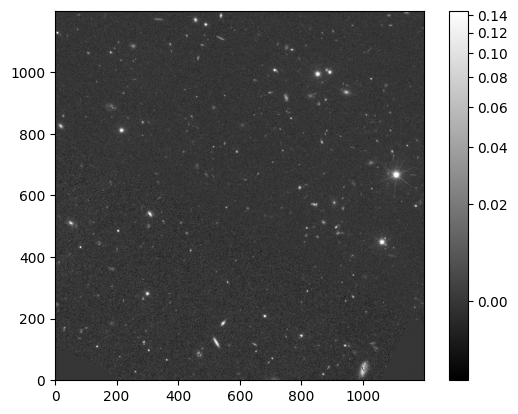

In [13]:
plt.imshow(im_mer_irsa[0:1200,0:1200], cmap='gray', origin='lower',
           norm=ImageNormalize(im_mer_irsa[0:1200,0:1200], interval=PercentileInterval(99.9), stretch=AsinhStretch()))
colorbar = plt.colorbar()

Uncomment the code below to plot an image of the entire field of view of the MER mosaic.

In [14]:
# # Full MER mosaic, may take a minute for python to create this image
# plt.imshow(im_mer_irsa, cmap='gray', origin='lower', norm=ImageNormalize(im_mer_irsa, interval=PercentileInterval(99.9), stretch=AsinhStretch()))
# colorbar = plt.colorbar()

## 3. Create multiwavelength Euclid Q1 MER cutouts of a region of interest

```{note}
We'd like to take a look at the multiwavelength images of our object, but the full MER mosaics are very large, so we will inspect the multiwavelength cutouts.
```

In [15]:
urls = science_images['access_url']

urls

https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/MEGACAM/EUC_MER_BGSUB-MOSAIC-CFIS-R_TILE102158277-CA7AB3_20241025T120300.417407Z_00.00.fits
https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/VIS/EUC_MER_BGSUB-MOSAIC-VIS_TILE102158277-27C4DD_20241025T124812.358980Z_00.00.fits
https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/MEGACAM/EUC_MER_BGSUB-MOSAIC-CFIS-U_TILE102158277-DB8920_20241025T120138.608462Z_00.00.fits
https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/HSC/EUC_MER_BGSUB-MOSAIC-WISHES-G_TILE102158277-76C6DB_20241025T120401.488065Z_00.00.fits
https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102158277-1FE0D9_20241025T122512.777703Z_00.00.fits
https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/HSC/EUC_MER_BGSUB-MOSAIC-WISHES-Z_TILE102158277-E3133D_20241025T120342.580582Z_00.00.fits
https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102158277-797A7D_20241025T122514.635323Z_00.00.fits
https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/GPC/EUC_MER_BGSUB-MOSAIC-PANSTARRS-I_TILE102158277-C2B970_20241025T120200.727193Z_00.00.fits
https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-J_TILE102158277-DA51EA_20241025T122533.612365Z_00.00.fits


Create an array with the instrument and filter name so we can add this to the plots.

In [16]:
science_images['filters'] = science_images['instrument_name'] + "_" + science_images['energy_bandpassname']

# VIS_VIS appears in the filters, so update that filter to just say VIS
science_images['filters'][science_images['filters']== 'VIS_VIS'] = "VIS"

science_images['filters']

MegaCam_R
VIS
MegaCam_U
Hyper Suprime-Cam_G
NISP_Y
Hyper Suprime-Cam_Z
NISP_H
Pan-STARRS_I
NISP_J


## The image above is very large, so let's cut out a smaller image to inspect these data.

In [17]:
######################## User defined section ############################
## How large do you want the image cutout to be?
im_cutout = 1.0 * u.arcmin

## What is the center of the cutout?
## For now choosing a random location on the image
## because the star itself is saturated
ra = 273.8667
dec =  64.525

## Bright star position
# ra = 273.474451
# dec = 64.397273

coords_cutout = SkyCoord(ra, dec, unit='deg', frame='icrs')

##########################################################################

## Iterate through each filter

cutout_list = []

for url in urls:
    ## Use fsspec to interact with the fits file without downloading the full file
    hdu = fits.open(url, use_fsspec=True)
    print(f"Opened {url}")

    ## Store the header
    header = hdu[0].header

    ## Read in the cutout of the image that you want
    cutout_data = Cutout2D(hdu[0].section, position=coords_cutout, size=im_cutout, wcs=WCS(hdu[0].header))

    ## Close the file
    # hdu.close()

    ## Define a new fits file based on this smaller cutout, with accurate WCS based on the cutout size
    new_hdu = fits.PrimaryHDU(data=cutout_data.data, header=header)
    new_hdu.header.update(cutout_data.wcs.to_header())

    ## Append the cutout to the list
    cutout_list.append(new_hdu)

## Combine all cutouts into a single HDUList and display information
final_hdulist = fits.HDUList(cutout_list)
final_hdulist.info()

Opened https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/MEGACAM/EUC_MER_BGSUB-MOSAIC-CFIS-R_TILE102158277-CA7AB3_20241025T120300.417407Z_00.00.fits
Opened https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/VIS/EUC_MER_BGSUB-MOSAIC-VIS_TILE102158277-27C4DD_20241025T124812.358980Z_00.00.fits
Opened https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/MEGACAM/EUC_MER_BGSUB-MOSAIC-CFIS-U_TILE102158277-DB8920_20241025T120138.608462Z_00.00.fits
Opened https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/HSC/EUC_MER_BGSUB-MOSAIC-WISHES-G_TILE102158277-76C6DB_20241025T120401.488065Z_00.00.fits
Opened https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102158277-1FE0D9_20241025T122512.777703Z_00.00.fits
Opened https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/HSC/EUC_MER_BGSUB-MOSAIC-WISHES-Z_TILE102158277-E3133D_20241025T120342.580582Z_00.00.fits
Opened https://irsa.ipac.caltech.edu/ibe/da

Opened https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/VIS/EUC_MER_BGSUB-MOSAIC-VIS_TILE102158277-27C4DD_20241025T124812.358980Z_00.00.fits


Opened https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/MEGACAM/EUC_MER_BGSUB-MOSAIC-CFIS-U_TILE102158277-DB8920_20241025T120138.608462Z_00.00.fits


Opened https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/HSC/EUC_MER_BGSUB-MOSAIC-WISHES-G_TILE102158277-76C6DB_20241025T120401.488065Z_00.00.fits


Opened https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102158277-1FE0D9_20241025T122512.777703Z_00.00.fits


Opened https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/HSC/EUC_MER_BGSUB-MOSAIC-WISHES-Z_TILE102158277-E3133D_20241025T120342.580582Z_00.00.fits


Opened https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102158277-797A7D_20241025T122514.635323Z_00.00.fits


Opened https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/GPC/EUC_MER_BGSUB-MOSAIC-PANSTARRS-I_TILE102158277-C2B970_20241025T120200.727193Z_00.00.fits


Opened https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-J_TILE102158277-DA51EA_20241025T122533.612365Z_00.00.fits


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      57   (600, 600)   float32   
  1  PRIMARY       1 PrimaryHDU      56   (600, 600)   float32   
  2  PRIMARY       1 PrimaryHDU      56   (600, 600)   float32   
  3  PRIMARY       1 PrimaryHDU      56   (600, 600)   float32   
  4  PRIMARY       1 PrimaryHDU      56   (600, 600)   float32   
  5  PRIMARY       1 PrimaryHDU      56   (600, 600)   float32   
  6  PRIMARY       1 PrimaryHDU      56   (600, 600)   float32   
  7  PRIMARY       1 PrimaryHDU      56   (600, 600)   float32   
  8  PRIMARY       1 PrimaryHDU      56   (600, 600)   float32   


## 3. Visualize multiwavelength Euclid Q1 MER cutouts

We need to determine the number of images for the grid layout, and then plot each cutout.

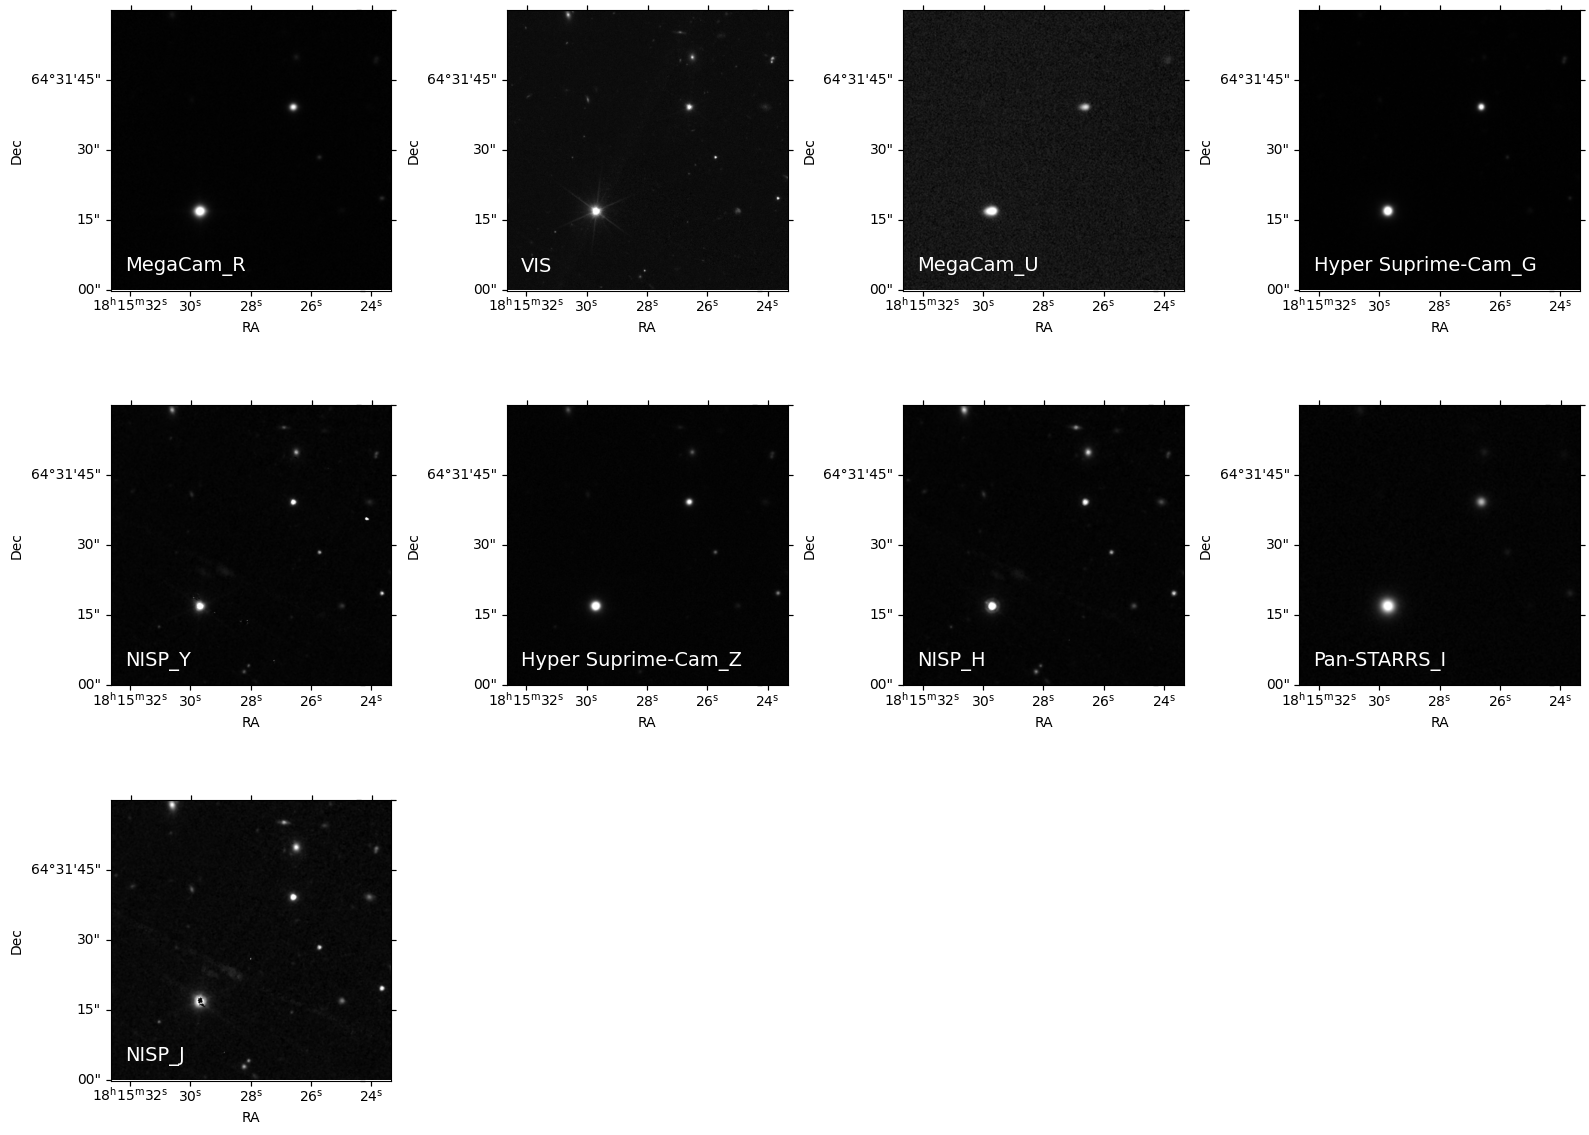

In [18]:
num_images = len(final_hdulist)
columns = 4
rows = -(-num_images // columns)

fig, axes = plt.subplots(rows, columns, figsize=(4 * columns, 4 * rows), subplot_kw={'projection': WCS(final_hdulist[0].header)})
axes = axes.flatten()

for idx, (ax, filt) in enumerate(zip(axes, science_images['filters'])):
    image_data = final_hdulist[idx].data
    norm = ImageNormalize(image_data, interval=PercentileInterval(99.9), stretch=AsinhStretch())
    ax.imshow(image_data, cmap='gray', origin='lower', norm=norm)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.text(0.05, 0.05, filt, color='white', fontsize=14, transform=ax.transAxes, va='bottom', ha='left')

## Remove empty subplots if any
for ax in axes[num_images:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

## 4. Use the Python package sep to identify and measure sources in the Euclid Q1 MER cutouts

First we list all the filters so you can choose which cutout you want to extract sources on. We will choose VIS.

In [19]:
filt_index = np.where(science_images['filters'] == 'VIS')[0][0]

img1 = final_hdulist[filt_index].data

### Extract some sources from the cutout using sep (python package based on source extractor)

Following the sep tutorial, first create a background for the cutout
https://sep.readthedocs.io/en/stable/tutorial.html

Need to do some initial steps (swap byte order) with the cutout to prevent sep from crashing. Then create a background model with sep.

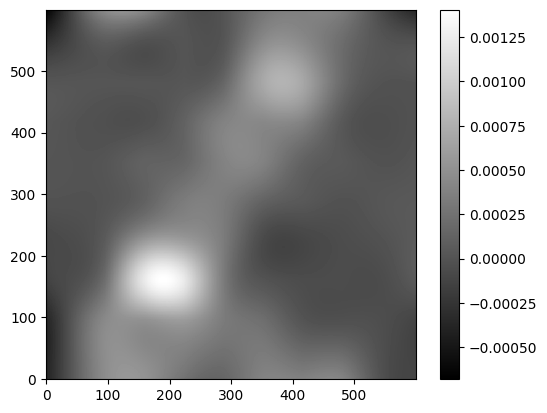

In [20]:
img2 = img1.byteswap().view(img1.dtype.newbyteorder())
c_contiguous_data = np.array(img2, dtype=np.float32)

bkg = sep.Background(c_contiguous_data)

bkg_image = bkg.back()

plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()

### Inspect the background rms as well

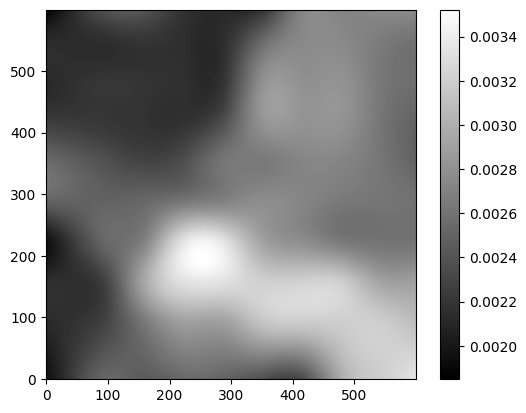

In [21]:
bkg_rms = bkg.rms()

plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

### Subtract the background

In [22]:
data_sub = img2 - bkg

### Source extraction via sep

In [23]:
######################## User defined section ############################

## Sigma threshold to consider this a detection above the global RMS
threshold= 3

## Minimum number of pixels required for an object. Default is 5.
minarea_0=2

## Minimum contrast ratio used for object deblending. Default is 0.005. To entirely disable deblending, set to 1.0.
deblend_cont_0= 0.005

flux_threshold= 0.01
##########################################################################


sources = sep.extract(data_sub, threshold, err=bkg.globalrms, minarea=minarea_0, deblend_cont=deblend_cont_0)
sources_thr = sources[sources['flux'] > flux_threshold]
print("Found", len(sources_thr), "objects above flux threshold")

Found 114 objects above flux threshold


## Lets have a look at the objects that were detected with sep in the cutout


We plot the VIS cutout with the sources detected overplotted with a red ellipse

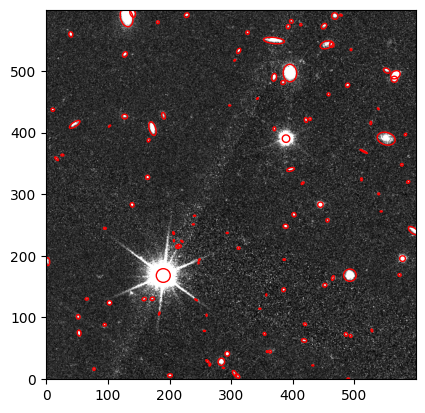

In [24]:
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, cmap='gray', origin='lower', norm=ImageNormalize(img2, interval=ZScaleInterval(), stretch=SquaredStretch()))

## Plot an ellipse for each object detected with sep

for i in range(len(sources_thr)):
    e = Ellipse(xy=(sources_thr['x'][i], sources_thr['y'][i]),
                width=6*sources_thr['a'][i],
                height=6*sources_thr['b'][i],
                angle=sources_thr['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

## About this Notebook

**Author**: Tiffany Meshkat, Anahita Alavi, Anastasia Laity, Andreas Faisst, Brigitta Sipőcz, Dan Masters, Harry Teplitz, Jaladh Singhal, Shoubaneh Hemmati, Vandana Desai

**Updated**: 2025-03-31

**Contact:** [the IRSA Helpdesk](https://irsa.ipac.caltech.edu/docs/help_desk.html) with questions or reporting problems.